In [4]:
import numpy as np
npz_data=np.load('/content/drive/MyDrive/Datasets/amazon_electronics_computers (1).npz')
npz_data.files


['adj_data',
 'adj_indices',
 'adj_indptr',
 'adj_shape',
 'attr_data',
 'attr_indices',
 'attr_indptr',
 'attr_shape',
 'labels',
 'class_names']

In [6]:
class_names =npz_data['class_names']
class_names

array(['Desktops', 'Data Storage', 'Laptops', 'Monitors',
       'Computer Components', 'Video Projectors', 'Routers', 'Tablets',
       'Networking Products', 'Webcams'], dtype='<U19')

In [7]:
#utils
import numpy as np
import scipy.sparse as sp
import torch
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, normalize


def load_data():

 features = sp.csr_matrix((npz_data['attr_data'], npz_data['attr_indices'], npz_data['attr_indptr']),
                                        shape=npz_data['attr_shape'])
  
 adj= sp.csr_matrix(sp.csr_matrix((npz_data['adj_data'], npz_data['adj_indices'], npz_data['adj_indptr']),
                                   shape=npz_data['adj_shape']))
  

 labels=npz_data['labels']
 labels=binarize_labels(labels)

 adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
 adj = normalize(adj + sp.eye(adj.shape[0]))

 idx_train = range(9100)
 idx_val = range(9100,11500)
 idx_test = range(11500, 13381)

 idx_train = torch.LongTensor(idx_train)
 idx_val = torch.LongTensor(idx_val)
 idx_test = torch.LongTensor(idx_test)

 features = torch.FloatTensor(np.array(features.todense()))
 labels = torch.LongTensor(np.where(labels)[1])
 #adj = sparse_mx_to_torch_sparse_tensor(adj)
 adj = torch.FloatTensor(np.array(adj.todense()))

 
 return adj, features, labels, idx_train, idx_val, idx_test
 

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    #sum in every row 
    r_inv = np.power(rowsum, -1).flatten()
    # every sum to the power of -1 
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    #diagonal matrice 
    mx = r_mat_inv.dot(mx)
    return mx


def binarize_labels(labels, sparse_output=False, return_classes=False):
    if hasattr(labels[0], '__iter__'):  # labels[0] is iterable <=> multilabel format
        binarizer = MultiLabelBinarizer(sparse_output=sparse_output)
    else:
        binarizer = LabelBinarizer(sparse_output=sparse_output)
    label_matrix = binarizer.fit_transform(labels).astype(np.float32)
    return (label_matrix, binarizer.classes_) if return_classes else label_matrix
 

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)    


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)    


In [8]:
adj, features, labels, idx_train, idx_val, idx_test = load_data()


In [9]:
features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 1., 1., 0.]])

In [10]:
features.shape

torch.Size([13752, 767])

In [11]:
features.min()
#feature ha 0 , 1 hastan

tensor(0.)

In [12]:
adj

tensor([[0.2000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0120, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0294,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0333, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0161, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0333]])

In [13]:
adj.shape

torch.Size([13752, 13752])

In [14]:
labels
#numbers from 0 to 9 ,indicating a category in class_names

tensor([4, 4, 8,  ..., 8, 4, 0])

In [15]:
labels.shape

torch.Size([13752])

In [16]:
XZ=np.insert(features,767,labels,axis=1)
XZ.shape
XZ
# inserting labels to the last column of feature
#having each node with its feature and label

tensor([[0., 0., 0.,  ..., 0., 0., 4.],
        [1., 1., 0.,  ..., 1., 0., 4.],
        [0., 0., 0.,  ..., 0., 0., 8.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 8.],
        [1., 0., 0.,  ..., 0., 0., 4.],
        [1., 1., 0.,  ..., 1., 0., 0.]])

In [17]:
AXZ=np.insert(XZ,0,adj,axis=1)
AXZ
# inserting adj to the first column of XZ
#having each node with its feature , label and relation with other nodes

tensor([[0.2000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 4.0000],
        [0.0000, 0.0120, 0.0000,  ..., 1.0000, 0.0000, 4.0000],
        [0.0000, 0.0000, 0.0294,  ..., 0.0000, 0.0000, 8.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 8.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 4.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000]])

In [18]:
AXZ.shape


torch.Size([13752, 14520])

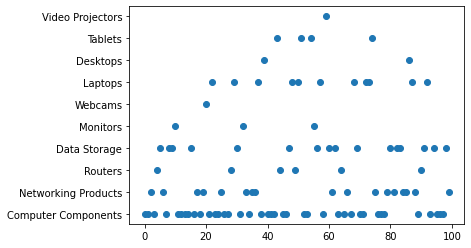

In [19]:
import matplotlib.pyplot as plt
x=idx_train[:100].tolist()
type(XZ)
y1=[]
i=0
while i < 100:
  y1=np.append(y1,class_names[int(XZ[(i,767)])])
  i=i+1

y1=y1.tolist()
plt.scatter(x, y1)
plt.show()
#plotting first 100 of x_train to show their categories